<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/deeplearning/blob/master/6/lab.ipynb">link</a>

Authorize google + kaggle

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


Be sure, that we authorized and have an access to kaggle

In [2]:
%ls /content/.kaggle/

kaggle.json*


# **Part 1: Download dataset, extract, split, check data distribution**

In [3]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download datamunge/sign-language-mnist -p /content/kaggle/signlanguage

 78% 49.0M/62.6M [00:02<00:01, 12.9MB/s]
100% 62.6M/62.6M [00:02<00:00, 23.3MB/s]


Extract .zip

In [4]:
!unzip kaggle/signlanguage/sign-language-mnist.zip -d data

Archive:  kaggle/signlanguage/sign-language-mnist.zip
  inflating: data/amer_sign2.png     
  inflating: data/amer_sign3.png     
  inflating: data/american_sign_language.PNG  
  inflating: data/sign_mnist_test.csv  
  inflating: data/sign_mnist_test/sign_mnist_test.csv  
  inflating: data/sign_mnist_train.csv  
  inflating: data/sign_mnist_train/sign_mnist_train.csv  


In [5]:
%ls

adc.json  data/  kaggle/  sample_data/


In [0]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

TRAIN_PATH = './data/sign_mnist_train.csv'
TEST_PATH = './data/sign_mnist_test.csv'

IMAGE_WIDTH=28
IMAGE_HEIGHT=28
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=1

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

train, val = train_test_split(train, test_size=0.2, random_state=42)


def split_dataset_to_x_y(df):
    y = pd.concat([df['label'], pd.get_dummies(df['label'], prefix='label')], axis=1)
    df.drop(['label'], axis=1, inplace=True)
    y.drop(['label'], axis=1, inplace=True)
    X = (df / 255).values.reshape((df.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))  # data scaling & reshaping

    return X, y


X_train, y_train = split_dataset_to_x_y(train)
X_val, y_val = split_dataset_to_x_y(val)
X_test, y_test = split_dataset_to_x_y(test)

Check data distribution

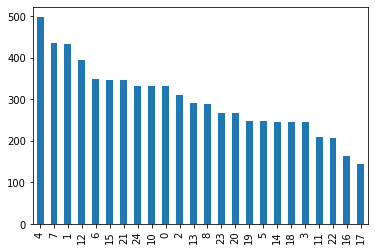

In [14]:
y_test.value_counts().plot.bar()

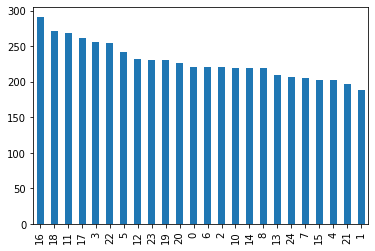

In [15]:
y_val.value_counts().plot.bar()

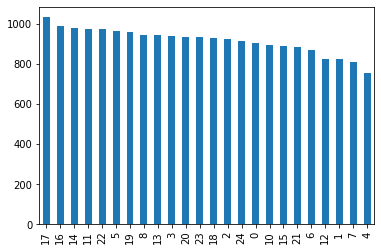

In [16]:
y_train.value_counts().plot.bar()

# **Part 2: DNN model**

In [62]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

LABELS = len(set(y_train))

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(LABELS, activation='softmax')) # 2 classes: dog and cat

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

model.save_weights('initial.h5')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_27 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_28 (Batc (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 64)         

Train without data augmentation:

In [64]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

model.load_weights('initial.h5')
# fits the model on batches:
model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) / 32,
    validation_data=datagen.flow(X_val, y_val),
    validation_steps=len(X_val) / 32,
    epochs=30
)

Epoch 1/30
687/686 [==============================] - 7s 11ms/step - loss: 1.2216 - acc: 0.6321 - val_loss: 0.1633 - val_acc: 0.9445
Epoch 2/30
687/686 [==============================] - 7s 11ms/step - loss: 0.2422 - acc: 0.9202 - val_loss: 0.0158 - val_acc: 0.9978
Epoch 3/30
687/686 [==============================] - 7s 11ms/step - loss: 0.1168 - acc: 0.9619 - val_loss: 0.0688 - val_acc: 0.9765
Epoch 4/30
687/686 [==============================] - 7s 11ms/step - loss: 0.0794 - acc: 0.9744 - val_loss: 0.0070 - val_acc: 0.9976
Epoch 5/30
687/686 [==============================] - 7s 10ms/step - loss: 0.0557 - acc: 0.9812 - val_loss: 0.0118 - val_acc: 0.9969
Epoch 6/30
687/686 [==============================] - 7s 11ms/step - loss: 0.0543 - acc: 0.9815 - val_loss: 0.0138 - val_acc: 0.9956
Epoch 7/30
687/686 [==============================] - 7s 10ms/step - loss: 0.0456 - acc: 0.9857 - val_loss: 0.0087 - val_acc: 0.9967
Epoch 8/30
687/686 [==============================] - 7s 10ms/step - 

Model evaluate:

In [65]:
score, acc = model.evaluate(X_test, y_test, verbose=1)
print(score, acc)

7172/7172 [==============================] - 1s 83us/step
0.25073102802432856 0.9563580591187953


# **Part 3: Applying data augmentation**

In [68]:
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

model.load_weights('initial.h5')
# fits the model on batches with real-time data augmentation:
model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) / 32,
    validation_data=datagen.flow(X_val, y_val),
    validation_steps=len(X_val) / 32,
    epochs=30
)

Epoch 1/30
687/686 [==============================] - 11s 15ms/step - loss: 1.7613 - acc: 0.4785 - val_loss: 0.7118 - val_acc: 0.7689
Epoch 2/30
687/686 [==============================] - 11s 15ms/step - loss: 0.7002 - acc: 0.7633 - val_loss: 0.4348 - val_acc: 0.8523
Epoch 3/30
687/686 [==============================] - 11s 15ms/step - loss: 0.4524 - acc: 0.8482 - val_loss: 1.2142 - val_acc: 0.6760
Epoch 4/30
687/686 [==============================] - 10s 15ms/step - loss: 0.3506 - acc: 0.8836 - val_loss: 0.3035 - val_acc: 0.8913
Epoch 5/30
687/686 [==============================] - 11s 16ms/step - loss: 0.2956 - acc: 0.8992 - val_loss: 0.1584 - val_acc: 0.9463
Epoch 6/30
687/686 [==============================] - 11s 15ms/step - loss: 0.2563 - acc: 0.9158 - val_loss: 1.3237 - val_acc: 0.6529
Epoch 7/30
687/686 [==============================] - 10s 15ms/step - loss: 0.2285 - acc: 0.9255 - val_loss: 0.0633 - val_acc: 0.9805
Epoch 8/30
687/686 [==============================] - 10s 15ms

Model evaluation

In [69]:
score, acc = model.evaluate(X_test, y_test, verbose=1)
print(score, acc)

7172/7172 [==============================] - 1s 88us/step
0.1272765828419629 0.9553820412716119


# **Part 4: Using transfer learning**

In [93]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
import numpy as np
import cv2

def x_to_vgg_input(X):
    x = [i for i in X]
    #x = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in X]
    #x = np.concatenate([arr[np.newaxis] for arr in x]).astype('float32')
    #x = [np.repeat(i[..., np.newaxis], 3, -1) for i in x]
    #x = np.repeat(x[..., np.newaxis], 3, -1)
    print(len(x[0]))
    return x

# load model
vgg = VGG16(include_top=False, input_shape=(32, 32, 3))
# mark loaded layers as not trainable
for layer in vgg.layers:
	layer.trainable = False

# define a new output layer to connect with the last fc layer in vgg
x = Flatten()(vgg.layers[-1].output)
class1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
bn = BatchNormalization()(class1)
do = Dropout(0.5)(bn)
output_layer = Dense(LABELS, activation='softmax', name='predictions')(do)

# combine the original VGG model with the new output layer
vgg = Model(inputs=vgg.input, outputs=output_layer)

vgg.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
x_to_vgg_input(X_train)
vgg.fit(
    x=x_to_vgg_input(X_train),
    y=y_train,
    batch_size=32,
    steps_per_epoch=len(X_train) / 32,
    epochs=30
)

28
28


ValueError: ignored